# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>


In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from assignment2.dataset import load_svhn, random_split_train_val
from assignment2.gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from assignment2.layers import FullyConnectedLayer, ReLULayer
from assignment2.model import TwoLayerNet
from assignment2.trainer import Trainer, Dataset 
from assignment2.optim import SGD, MomentumSGD
from assignment2.metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [6]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [7]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

run batch version of gradient check
  analytic_grad
 [[ 1.61599406  0.          2.76252524]
 [-0.         -0.5060347  -0.94302519]] 

  numeric_grad
 [[ 1.61599406  0.          2.76252524]
 [ 0.         -0.5060347  -0.94302519]] 

Gradient check passed!



А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [8]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

run batch version of gradient check
  analytic_grad
 [[ 4.18948095e-04  1.76337767e-03 -3.49979411e-04]
 [ 7.82747412e-05 -6.12293143e-04 -1.09946675e-03]] 

  numeric_grad
 [[ 4.18948095e-04  1.76337767e-03 -3.49979411e-04]
 [ 7.82747412e-05 -6.12293143e-04 -1.09946675e-03]] 

Gradient check passed!

run batch version of gradient check
  analytic_grad
 [[-1.67429365  2.15318718 -0.15893916 -0.56958173]
 [ 3.34858731 -4.30637437  0.31787831  1.13916345]
 [-0.36258122  5.45842018 -3.37773459 -0.89339967]] 

  numeric_grad
 [[-1.67429365  2.15318718 -0.15893916 -0.56958173]
 [ 3.34858731 -4.30637437  0.31787831  1.13916345]
 [-0.36258122  5.45842018 -3.37773459 -0.89339967]] 

Gradient check passed!

run batch version of gradient check
  analytic_grad
 [[-0.632844   -0.39002832  1.75340995  0.51081366]] 

  numeric_grad
 [[-0.632844   -0.39002832  1.75340995  0.51081366]] 

Gradient check passed!



## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [9]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for fc1_W
run batch version of gradient check
  analytic_grad
 [[ 1.05393580e-05  0.00000000e+00 -2.23528083e-05]
 [ 1.25578983e-05  0.00000000e+00 -4.99938161e-06]
 [ 3.57140937e-05  0.00000000e+00  4.39014438e-05]
 ...
 [-9.80687160e-05  0.00000000e+00 -8.39833186e-05]
 [-8.76305797e-05  0.00000000e+00 -5.28532904e-05]
 [-6.98006962e-05  0.00000000e+00 -2.94876473e-06]] 

  numeric_grad
 [[ 1.05393694e-05  0.00000000e+00 -2.23528085e-05]
 [ 1.25578881e-05  0.00000000e+00 -4.99937869e-06]
 [ 3.57140983e-05  0.00000000e+00  4.39014158e-05]
 ...
 [-9.80687087e-05  0.00000000e+00 -8.39833092e-05]
 [-8.76305917e-05  0.00000000e+00 -5.28532773e-05]
 [-6.98006986e-05  0.00000000e+00 -2.94875235e-06]] 

Gradient check passed!

Checking gradient for fc1_B
run batch version of gradient check
  analytic_grad
 [[0.00065346 0.         0.0006072 ]] 

  numeric_grad
 [[0.00065346 0.         0.0006072 ]] 

Gradient check passed!

Checking gradient for fc2_W
run batch version of gra

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [10]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for fc1_W
run batch version of gradient check
  analytic_grad
 [[-0.01976325 -0.00117834 -0.02135352]
 [ 0.01538378  0.0081576   0.01097304]
 [ 0.02261739 -0.00670261  0.02142476]
 ...
 [-0.00958147  0.00678107 -0.00191968]
 [ 0.03099914 -0.00714554  0.00908816]
 [ 0.02173933  0.0131764   0.01097147]] 

  numeric_grad
 [[-0.01976325 -0.00117834 -0.02135352]
 [ 0.01538378  0.0081576   0.01097304]
 [ 0.02261739 -0.00670261  0.02142476]
 ...
 [-0.00958147  0.00678107 -0.00191968]
 [ 0.03099914 -0.00714554  0.00908816]
 [ 0.02173933  0.0131764   0.01097147]] 

Gradient check passed!

Checking gradient for fc1_B
run batch version of gradient check
  analytic_grad
 [[-0.01013572  0.0029346   0.00803137]] 

  numeric_grad
 [[-0.01013572  0.0029346   0.00803137]] 

Gradient check passed!

Checking gradient for fc2_W
run batch version of gradient check
  analytic_grad
 [[ 0.00339013  0.02963675 -0.00331576  0.00066842  0.05166266  0.01660512
  -0.01936271  0.00995913  0.015861

True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [11]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [12]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, 
                    hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-1, num_epochs=10)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 1.973762, Train accuracy: 0.230889, val accuracy: 0.252000, lr: 0.100000
Loss: 1.751880, Train accuracy: 0.428667, val accuracy: 0.434000, lr: 0.100000
Loss: 1.161730, Train accuracy: 0.514444, val accuracy: 0.530000, lr: 0.100000
Loss: 1.198346, Train accuracy: 0.604667, val accuracy: 0.587000, lr: 0.100000
Loss: 1.090121, Train accuracy: 0.671111, val accuracy: 0.651000, lr: 0.100000
Loss: 0.471595, Train accuracy: 0.710889, val accuracy: 0.680000, lr: 0.100000
Loss: 0.737977, Train accuracy: 0.713111, val accuracy: 0.682000, lr: 0.100000
Loss: 0.547223, Train accuracy: 0.747222, val accuracy: 0.689000, lr: 0.100000
Loss: 1.080923, Train accuracy: 0.738556, val accuracy: 0.706000, lr: 0.100000
Loss: 0.420400, Train accuracy: 0.755222, val accuracy: 0.704000, lr: 0.100000


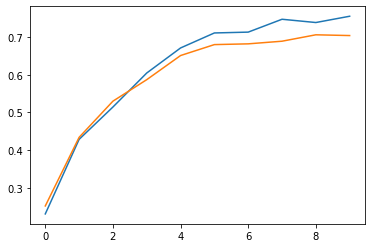

In [13]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [14]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, 
                    reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, 
                  learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.167917, Train accuracy: 0.220778, val accuracy: 0.236000, lr: 0.099000
Loss: 2.058752, Train accuracy: 0.398222, val accuracy: 0.393000, lr: 0.098010
Loss: 0.976473, Train accuracy: 0.540778, val accuracy: 0.553000, lr: 0.097030
Loss: 1.270165, Train accuracy: 0.614333, val accuracy: 0.607000, lr: 0.096060
Loss: 1.090307, Train accuracy: 0.636667, val accuracy: 0.636000, lr: 0.095099
Loss: 1.108789, Train accuracy: 0.673778, val accuracy: 0.644000, lr: 0.094148
Loss: 0.785766, Train accuracy: 0.721889, val accuracy: 0.695000, lr: 0.093207
Loss: 1.127368, Train accuracy: 0.721556, val accuracy: 0.667000, lr: 0.092274
Loss: 0.878017, Train accuracy: 0.745556, val accuracy: 0.700000, lr: 0.091352
Loss: 1.079874, Train accuracy: 0.765778, val accuracy: 0.693000, lr: 0.090438
Loss: 1.293783, Train accuracy: 0.768222, val accuracy: 0.690000, lr: 0.089534
Loss: 0.837942, Train accuracy: 0.784889, val accuracy: 0.702000, lr: 0.088638
Loss: 0.681580, Train accuracy: 0.817444, val accura

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [15]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, 
                    reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), 
                  learning_rate=1e-1, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.092324, Train accuracy: 0.222556, val accuracy: 0.229000, lr: 0.099000
Loss: 1.860824, Train accuracy: 0.379556, val accuracy: 0.389000, lr: 0.098010
Loss: 1.590450, Train accuracy: 0.505556, val accuracy: 0.517000, lr: 0.097030
Loss: 1.847590, Train accuracy: 0.636556, val accuracy: 0.627000, lr: 0.096060
Loss: 1.432718, Train accuracy: 0.672444, val accuracy: 0.667000, lr: 0.095099
Loss: 1.785398, Train accuracy: 0.718222, val accuracy: 0.693000, lr: 0.094148
Loss: 0.947681, Train accuracy: 0.698778, val accuracy: 0.670000, lr: 0.093207
Loss: 1.096071, Train accuracy: 0.721889, val accuracy: 0.676000, lr: 0.092274
Loss: 0.648033, Train accuracy: 0.732556, val accuracy: 0.688000, lr: 0.091352
Loss: 0.707297, Train accuracy: 0.747889, val accuracy: 0.704000, lr: 0.090438
Loss: 0.667226, Train accuracy: 0.753556, val accuracy: 0.693000, lr: 0.089534
Loss: 0.513031, Train accuracy: 0.778556, val accuracy: 0.712000, lr: 0.088638
Loss: 0.717841, Train accuracy: 0.807667, val accura

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [16]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, 
                    reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.343311, Train accuracy: 0.200000, val accuracy: 0.133333, lr: 0.100000
Loss: 2.319494, Train accuracy: 0.200000, val accuracy: 0.133333, lr: 0.100000
Loss: 2.344415, Train accuracy: 0.200000, val accuracy: 0.133333, lr: 0.100000
Loss: 2.301831, Train accuracy: 0.200000, val accuracy: 0.133333, lr: 0.100000
Loss: 2.282484, Train accuracy: 0.200000, val accuracy: 0.133333, lr: 0.100000
Loss: 2.227485, Train accuracy: 0.200000, val accuracy: 0.066667, lr: 0.100000
Loss: 2.247323, Train accuracy: 0.200000, val accuracy: 0.066667, lr: 0.100000
Loss: 2.170390, Train accuracy: 0.200000, val accuracy: 0.133333, lr: 0.100000
Loss: 2.228315, Train accuracy: 0.400000, val accuracy: 0.000000, lr: 0.100000
Loss: 2.353823, Train accuracy: 0.400000, val accuracy: 0.000000, lr: 0.100000
Loss: 2.006564, Train accuracy: 0.400000, val accuracy: 0.000000, lr: 0.100000
Loss: 2.127238, Train accuracy: 0.400000, val accuracy: 0.000000, lr: 0.100000
Loss: 1.608926, Train accuracy: 0.400000, val accura

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [42]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, 
                    reg = 0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=3e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.339336, Train accuracy: 0.200000, val accuracy: 0.133333, lr: 0.300000
Loss: 2.278314, Train accuracy: 0.200000, val accuracy: 0.133333, lr: 0.300000
Loss: 2.266186, Train accuracy: 0.200000, val accuracy: 0.133333, lr: 0.300000
Loss: 2.322997, Train accuracy: 0.400000, val accuracy: 0.000000, lr: 0.300000
Loss: 2.072852, Train accuracy: 0.333333, val accuracy: 0.000000, lr: 0.300000
Loss: 2.331758, Train accuracy: 0.333333, val accuracy: 0.066667, lr: 0.300000
Loss: 1.979863, Train accuracy: 0.466667, val accuracy: 0.133333, lr: 0.300000
Loss: 1.609449, Train accuracy: 0.466667, val accuracy: 0.000000, lr: 0.300000
Loss: 1.739748, Train accuracy: 0.400000, val accuracy: 0.000000, lr: 0.300000
Loss: 1.246179, Train accuracy: 0.400000, val accuracy: 0.066667, lr: 0.300000
Loss: 1.246652, Train accuracy: 0.466667, val accuracy: 0.000000, lr: 0.300000
Loss: 1.905688, Train accuracy: 0.466667, val accuracy: 0.066667, lr: 0.300000
Loss: 1.475181, Train accuracy: 0.666667, val accura

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [ ]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-1
reg_strength = 1e-5
learning_rate_decay = 0.99
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of validation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))